In [1]:
from pyddm import Model
from pyddm.models import DriftLinear
from pyddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, ICPointSourceCenter
from pyddm.functions import fit_adjust_model, display_model
import numpy as np

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
%run IDM_helper_functions.ipynb

import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

from sbi.inference import MNLE
from pyro.distributions import InverseGamma
from torch.distributions import Beta, Binomial, Gamma
from sbi.utils import MultipleIndependent

from sbi.inference import MCMCPosterior, VIPosterior, RejectionPosterior
from sbi.utils.torchutils import atleast_2d

from sbi.utils import mcmc_transform
from sbi.inference.potentials.base_potential import BasePotential

## LCA parameter recovery

In [13]:
# Training data
num_simulations = 50000

prior = utils.BoxUniform(low=[0,0.6,0.01], high=[0.5,2, 6])

parameters = prior.sample((num_simulations,))
x = simul_LCA(np.array(parameters))

In [14]:
# Train MNLE and obtain MCMC-based posterior.

trainer = MNLE(prior=prior)
trainer = trainer.append_simulations(parameters, x)
mnle = trainer.train()


 Neural network successfully converged after 29 epochs.

In [15]:
mcmc_parameters = dict(num_chains=50,thin=10,warmup_steps=50,init_strategy="proposal")

In [84]:
# inference with different x_o that has 10 trials
#torch.manual_seed(41)
num_trials = 100
num_samples = 100
parameters_o = prior.sample((1,))
#x_o = simul_IDM_mult_trial(np.array(parameters_o))
x_o = simul_LCA(np.array(parameters_o.repeat(num_trials, 1)))

In [85]:
mnle_posterior = trainer.build_posterior(mnle, prior)

mnle_samples = mnle_posterior.sample((num_samples,), x=x_o)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

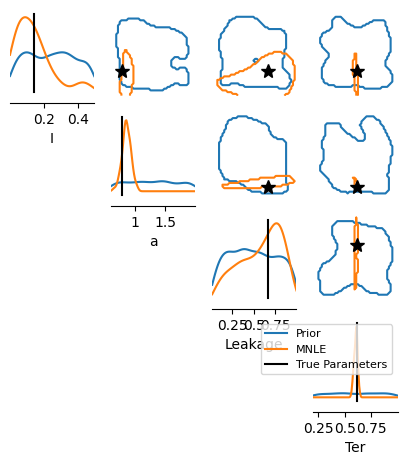

In [86]:
#pair_plot(prior, mnle_samples, parameters_o, 
contour = 0.5

fig, ax = pairplot(
    [
        prior.sample((1000,)),
        mnle_samples,
    ],
    points=parameters_o,
    diag="kde",
    upper="contour",
    kde_offdiag=dict(bins=50),
    kde_diag=dict(bins=100),
    #contour_offdiag=dict(levels=[contour]),
    points_colors=["k"],
    points_offdiag=dict(marker="*", markersize=10),
    labels=['I', 'a','Leakage','Ter'],
    figsize=(5, 5)
)

#plt.sca(ax[1, 1])
plt.legend(
    ["Prior", "MNLE", 'True Parameters'],
    #frameon=False,
    fontsize=8,
    loc = 1
);

## Simulate from IDM and fit with ICA

In [18]:
Cs = np.random.uniform(low=0, high=0.5, size=30)
hs = np.random.uniform(low=0.2, high=0.4, size=30)
Inhs = np.random.uniform(low=8200, high=8600, size=30)
Excs = np.random.uniform(low=52300, high=52700, size=30)

#Ters = np.random.uniform(low=0.2, high=0.8, size=30)

n_trials = 200
num_samples = 100
par_fitted = np.zeros((30,3))

In [19]:
for i in range(len(Cs)):
    print(i)
    IDM_o = simul_IDM_CG_inh_pos(np.tile((Cs[i], hs[i], Inhs[i], Excs[i]), (n_trials,1))) # simulate IDM data
    print(IDM_o[0:5,:])
    mnle_posterior = trainer.build_posterior(
    mcmc_method="slice_np_vectorized", mcmc_parameters=mcmc_parameters, prior = prior
    )
    
    #mnle_samples = mnle_posterior.sample((num_samples,), x=x_o) # fit with IDM
    mnle_posterior.set_default_x(IDM_o)
    mnle_map = mnle_posterior.map()
    print(np.array(mnle_map))
    par_fitted[i,:] = np.array(mnle_map)
    
    

0
sim0
tensor([[0.6040, 0.0000],
        [0.6290, 0.0000],
        [0.6160, 0.0000],
        [0.5830, 0.0000],
        [0.6520, 0.0000]])
[0.49832803 0.8016558  5.9934206 ]
1
sim0
tensor([[0.6500, 0.0000],
        [0.6260, 0.0000],
        [0.6670, 0.0000],
        [0.6450, 1.0000],
        [0.6440, 1.0000]])
[0.49999422 0.9728365  5.9983606 ]
2
sim0
tensor([[0.6090, 0.0000],
        [0.5970, 0.0000],
        [0.6110, 0.0000],
        [0.6000, 0.0000],
        [0.5990, 0.0000]])
[0.49823552 0.70273894 5.994752  ]
3
sim0
tensor([[0.5920, 0.0000],
        [0.6100, 0.0000],
        [0.6410, 0.0000],
        [0.6260, 0.0000],
        [0.6420, 0.0000]])
[0.4997586 0.8947196 5.9965606]
4
sim0
tensor([[0.6440, 0.0000],
        [0.6280, 0.0000],
        [0.6530, 0.0000],
        [0.6110, 0.0000],
        [0.5980, 0.0000]])
[0.49905163 0.923246   5.9908404 ]
5
sim0
tensor([[0.5920, 0.0000],
        [0.5910, 0.0000],
        [0.5760, 0.0000],
        [0.5730, 0.0000],
        [0.5600, 0.0000]])


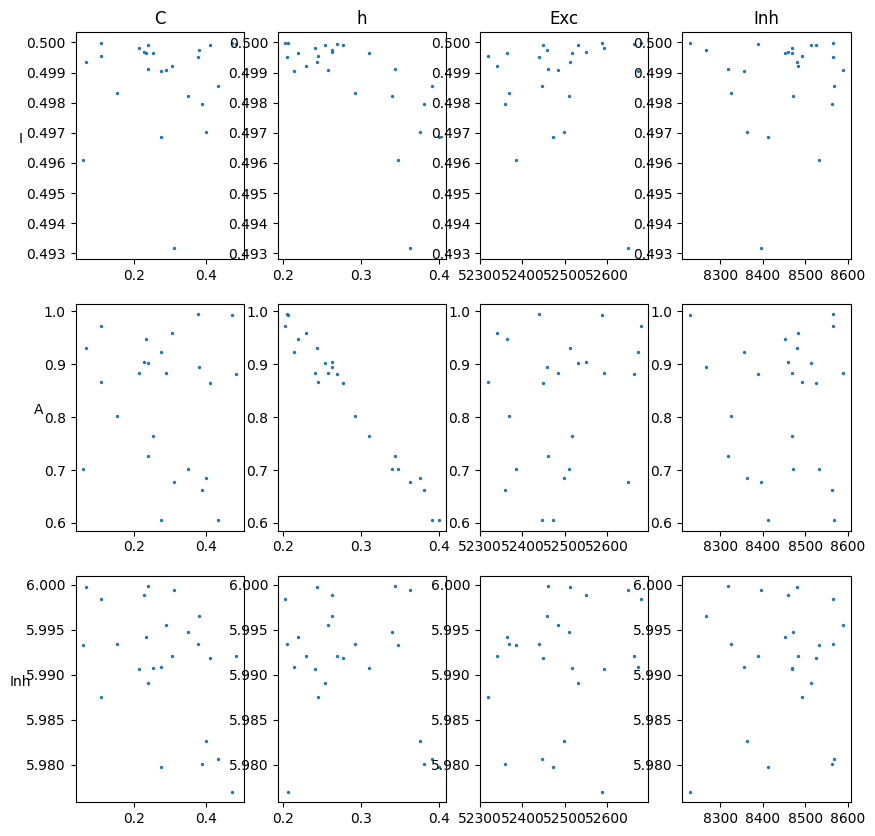

In [20]:
sim_fit_plot_IDM_LCA(Cs, hs, Excs, Inhs, par_fitted, sim_num = 25)

## Train NN for IDM 

In [148]:
# Training data
num_simulations = 40000
prior = utils.BoxUniform(low=[0,0.2,6000], high=[0.5,0.6,8000])

parameters = prior.sample((num_simulations,))
x = simul_IDM_CG_inh(np.array(parameters))

sim0
sim1000
sim2000
sim3000
sim4000
sim5000
sim6000
sim7000
sim8000
sim9000
sim10000
sim11000
sim12000
sim13000
sim14000
sim15000
sim16000
sim17000
sim18000
sim19000
sim20000
sim21000
sim22000
sim23000
sim24000
sim25000
sim26000
sim27000
sim28000
sim29000
sim30000
sim31000
sim32000
sim33000
sim34000
sim35000
sim36000
sim37000
sim38000
sim39000


In [149]:
# Train MNLE and obtain MCMC-based posterior.

trainer = MNLE(prior=prior)
trainer = trainer.append_simulations(parameters, x)
mnle = trainer.train()
mcmc_parameters = dict(num_chains=50,thin=10,warmup_steps=50,init_strategy="proposal")


 Neural network successfully converged after 70 epochs.

## IDM parameter recovery

In [ ]:
# inference with different x_o that has 10 trials
num_trials = 100
num_samples = 100
parameters_o = prior.sample((1,))
#x_o = simul_IDM_mult_trial(np.array(parameters_o))
x_o = simul_IDM_CG_inh(np.array(parameters_o.repeat(num_trials, 1)))

In [ ]:
mnle_posterior = trainer.build_posterior(mnle, prior)

mnle_samples = mnle_posterior.sample((num_samples,), x=x_o)

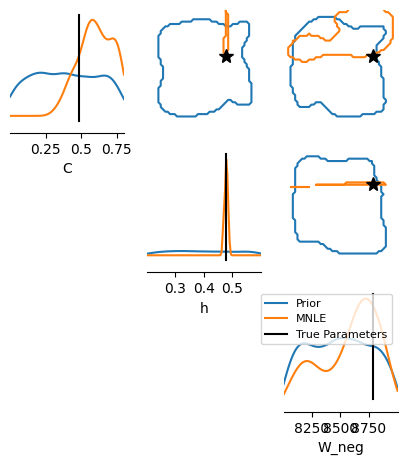

In [95]:
#pair_plot(prior, mnle_samples, parameters_o, 
contour = 0.7

fig, ax = pairplot(
    [
        prior.sample((1000,)),
        mnle_samples,
    ],
    points=parameters_o,
    diag="kde",
    upper="contour",
    kde_offdiag=dict(bins=50),
    kde_diag=dict(bins=100),
    contour_offdiag=dict(levels=[contour]),
    points_colors=["k"],
    points_offdiag=dict(marker="*", markersize=10),
    labels=['C', 'h','W_neg'],
    figsize=(5, 5)
)

#plt.sca(ax[1, 1])
plt.legend(
    ["Prior", "MNLE", 'True Parameters'],
    #frameon=False,
    fontsize=8,
    loc = 1
);

## Simulate from LCA and fit with IDM

In [150]:
Is = np.random.uniform(low=0.1, high=4, size=30)
As = np.random.uniform(low=0.4, high=0.8, size=30)
Inhs = np.random.uniform(low=0.1, high=4, size=30)
#Ters = np.random.uniform(low=0.2, high=0.8, size=30)

n_trials = 500
num_samples = 100
par_fitted = np.zeros((30,3))

In [151]:
for i in range(len(Is)):
    print(i)
    LCA_o = simul_LCA(np.tile((Is[i], As[i], Inhs[i]), (n_trials,1))) # simulate IDM data
    print(LCA_o[0:5,:])
    #prior = utils.BoxUniform(low=[0,0.2,0.1], high=[0.6,0.6,0.6])
    mnle_posterior = trainer.build_posterior(
    mcmc_method="slice_np_vectorized", mcmc_parameters=mcmc_parameters, prior = prior
    )
    
    #mnle_samples = mnle_posterior.sample((num_samples,), x=x_o) # fit with IDM
    mnle_posterior.set_default_x(LCA_o)
    mnle_map = mnle_posterior.map()
    print(np.array(mnle_map))
    par_fitted[i,:] = np.array(mnle_map)
    
    

0
tensor([[1.4020, 0.0000],
        [0.8870, 0.0000],
        [0.5680, 1.0000],
        [0.6120, 1.0000],
        [0.7680, 0.0000]])
[2.0425561e-01 4.0492842e-01 6.8782568e+03]
1
tensor([[0.5740, 0.0000],
        [0.6490, 0.0000],
        [0.5950, 0.0000],
        [0.6080, 0.0000],
        [0.6730, 0.0000]])
[3.1178629e-01 4.0015432e-01 6.7044673e+03]
2
tensor([[0.6520, 0.0000],
        [0.6730, 0.0000],
        [0.5450, 0.0000],
        [0.6270, 0.0000],
        [0.5610, 0.0000]])
[3.2582918e-01 3.7295932e-01 6.6481040e+03]
3
tensor([[0.7700, 1.0000],
        [0.5440, 1.0000],
        [0.8770, 0.0000],
        [0.6530, 1.0000],
        [0.8140, 0.0000]])
[3.1458724e-01 3.6899114e-01 6.6702173e+03]
4
tensor([[0.7770, 0.0000],
        [0.6260, 0.0000],
        [0.5700, 0.0000],
        [0.5200, 0.0000],
        [0.5620, 0.0000]])
[3.3504364e-01 4.6827739e-01 6.6119951e+03]
5
tensor([[0.5310, 0.0000],
        [0.5920, 0.0000],
        [0.7040, 0.0000],
        [0.6560, 0.0000],
        [

Text(0, 0.5, 'W_neg')

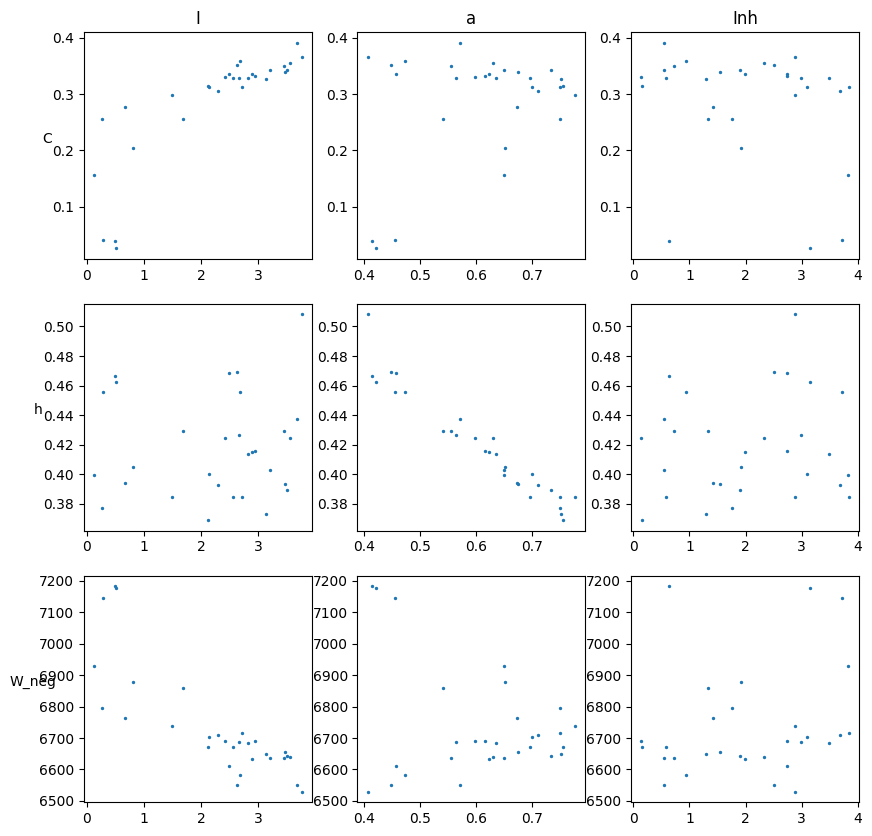

In [152]:
sim_num = 30
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(10,10))

ax1.scatter(Is[0:sim_num], par_fitted[0:sim_num,0], s = 2)
ax2.scatter(As[0:sim_num], par_fitted[0:sim_num,0], s = 2)
ax3.scatter(Inhs[0:sim_num], par_fitted[0:sim_num,0], s = 2)
ax4.scatter(Is[0:sim_num], par_fitted[0:sim_num,1], s = 2)
ax5.scatter(As[0:sim_num], par_fitted[0:sim_num,1], s = 2)
ax6.scatter(Inhs[0:sim_num], par_fitted[0:sim_num,1], s = 2)
ax7.scatter(Is[0:sim_num], par_fitted[0:sim_num,2], s = 2)
ax8.scatter(As[0:sim_num], par_fitted[0:sim_num,2], s = 2)
ax9.scatter(Inhs[0:sim_num], par_fitted[0:sim_num,2], s = 2)

ax1.set_title("I")
ax2.set_title("a")
ax3.set_title("Inh")

ax1.set_ylabel("C", rotation=0)
ax4.set_ylabel("h", rotation=0)
ax7.set_ylabel("W_neg", rotation=0)

Text(0, 0.5, 'W_neg')

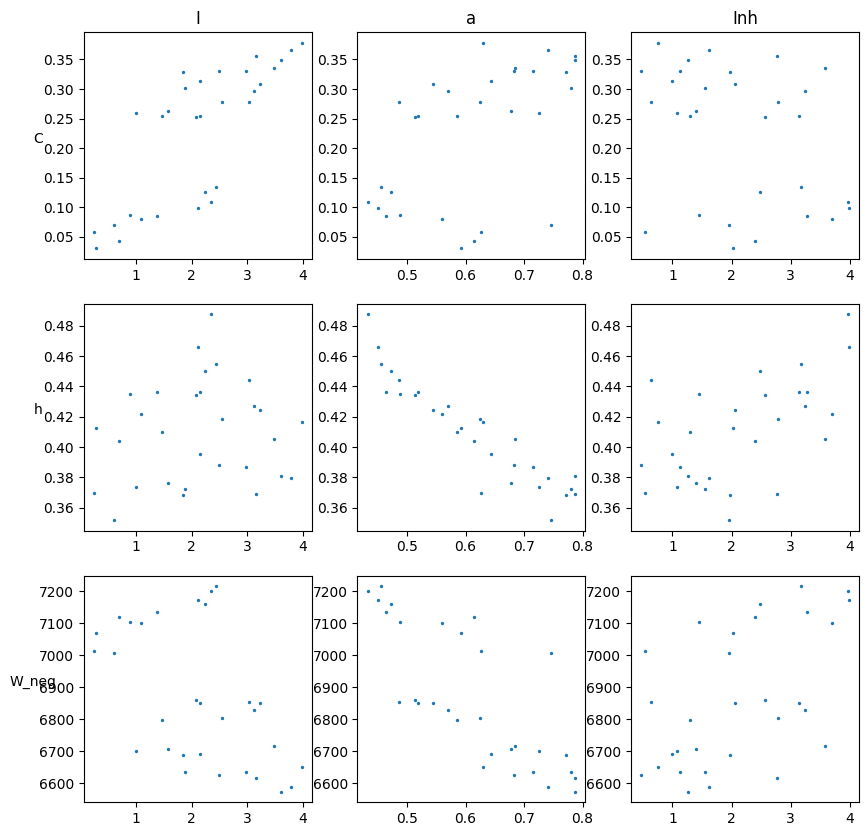

In [147]:
sim_num = 30
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(10,10))

ax1.scatter(Is[0:sim_num], par_fitted[0:sim_num,0], s = 2)
ax2.scatter(As[0:sim_num], par_fitted[0:sim_num,0], s = 2)
ax3.scatter(Inhs[0:sim_num], par_fitted[0:sim_num,0], s = 2)
ax4.scatter(Is[0:sim_num], par_fitted[0:sim_num,1], s = 2)
ax5.scatter(As[0:sim_num], par_fitted[0:sim_num,1], s = 2)
ax6.scatter(Inhs[0:sim_num], par_fitted[0:sim_num,1], s = 2)
ax7.scatter(Is[0:sim_num], par_fitted[0:sim_num,2], s = 2)
ax8.scatter(As[0:sim_num], par_fitted[0:sim_num,2], s = 2)
ax9.scatter(Inhs[0:sim_num], par_fitted[0:sim_num,2], s = 2)

ax1.set_title("I")
ax2.set_title("a")
ax3.set_title("Inh")

ax1.set_ylabel("C", rotation=0)
ax4.set_ylabel("h", rotation=0)
ax7.set_ylabel("W_neg", rotation=0)